In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jpholiday

In [2]:
import xgboost as xgb

In [2]:
df = pd.read_excel('/Users/hiraokatatsuru/Library/CloudStorage/OneDrive-個人用/ドキュメント/物数データ.xlsx')
df.set_index('date', inplace=True)

In [14]:
df

,通常物数,lag_1,lag_7,month,rolling_mean_7,is_obon,is_new_year,dow,dow_sin,dow_cos,is_holiday,is_after_holiday,is_after_after_holiday,is_weekend
date,,,,,,,,,,,,,,
2021-10-08,71000,58000.0,63000.0,10,47285.714286,0,0,4,-0.433884,-0.900969,0,0,0,False
2021-10-09,0,71000.0,0.0,10,47285.714286,0,0,5,-0.974928,-0.222521,0,0,0,True
2021-10-10,0,0.0,0.0,10,47285.714286,0,0,6,-0.781831,0.623490,0,0,0,True
2021-10-11,96000,0.0,102000.0,10,46428.571429,0,0,0,0.000000,1.000000,0,0,0,False
2021-10-12,51000,96000.0,45000.0,10,47285.714286,0,0,1,0.781831,0.623490,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-27,29000,75000.0,28000.0,5,29428.571429,0,0,1,0.781831,0.623490,0,0,0,False
2025-05-28,32000,29000.0,29000.0,5,29857.142857,0,0,2,0.974928,-0.222521,0,0,0,False
2025-05-29,36000,32000.0,36000.0,5,29857.142857,0,0,3,0.433884,-0.900969,0,0,0,False


In [4]:
# 過去1日の郵便物数（lag_1）を追加
df['lag_1'] = df['通常物数'].shift(1)

# 過去7日の郵便物数（lag_7）を追加
df['lag_7'] = df['通常物数'].shift(7)

In [13]:
# NaN の行を一括で削除
df = df.dropna().copy()

In [5]:
# 月ごとに分ける
df['month'] = df.index.month

In [6]:
# 過去7日間の移動平均を計算して新しい列として追加
df['rolling_mean_7'] = df['通常物数'].rolling(window=7).mean()

In [7]:
# お盆フラグを作成（例: 8月10日〜8月20日）
#df['is_obon'] = ((df.index.month == 8) & (df.index.day >= 10) & (df.index.day <= 20)).astype(int)
# お盆フラグ（8月13〜17日、土日祝を除く）
df['is_obon'] = (
    (df.index.month == 8) & 
    (df.index.day >= 10) & 
    (df.index.day <= 20)).astype(int)

In [8]:
# 年末年始フラグ（12月29〜1月5日、土日祝を除く）
df['is_new_year'] = (
    (((df.index.month == 12) & (df.index.day >= 26)) | 
     ((df.index.month == 1) & (df.index.day <= 10)))).astype(int)

In [9]:
# 1. dayofweek を取得
df['dow'] = df.index.dayofweek  # 0～6

# 2. サイン & コサイン変換
df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)

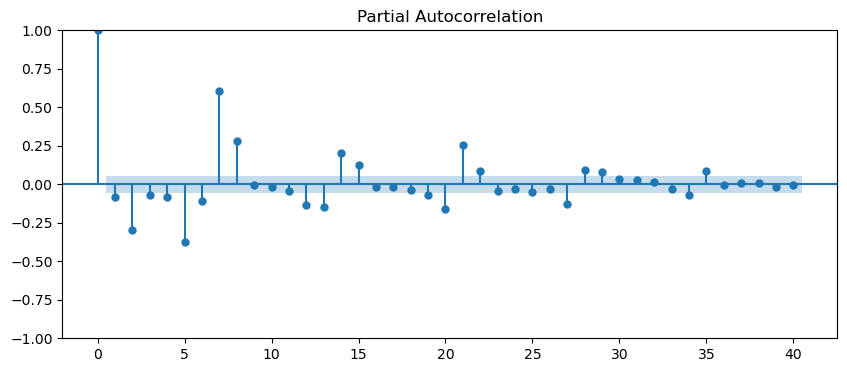

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf
y = df['通常物数']

fig, ax = plt.subplots(figsize=(10,4))
plot_pacf(y, ax=ax, lags=40)  # ラグ40までなど任意で設定
plt.show()

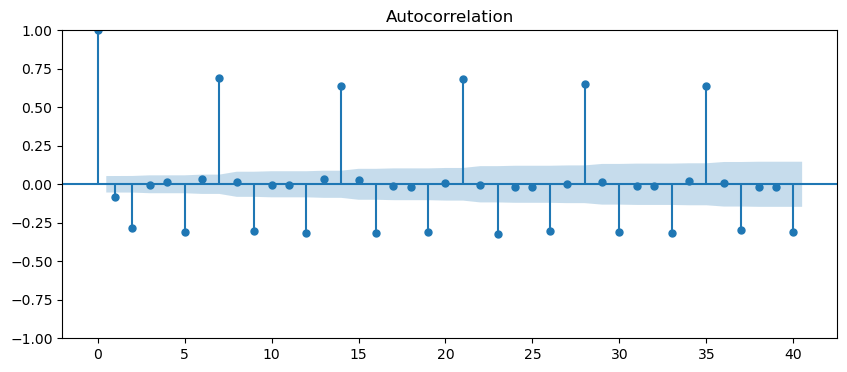

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
y = df['通常物数']

fig, ax = plt.subplots(figsize=(10,4))
plot_acf(y, ax=ax, lags=40)  # ラグ40までなど任意で設定
plt.show()

In [10]:
# 祝日フラグを数値型（1: 祝日、0: 平日）に変換
# まず jpholiday で祝日判定
df['is_holiday'] = df.index.map(lambda x: int(jpholiday.is_holiday(x)))

# 1月1日は強制的に 0
df.loc[(df.index.month == 1) & (df.index.day == 1), 'is_holiday'] = 0

# 1月2日は強制的に 1
df.loc[(df.index.month == 1) & (df.index.day == 2), 'is_holiday'] = 1

In [11]:
df['is_after_holiday'] = (
        (df['is_holiday'].shift(1) == 1) & 
        (df['is_holiday'] == 0)
    ).astype(int)
    
# 前日が "祝日明け" フラグ == 1 かつ 当日は祝日ではない → "祝日明けの翌日"
df['is_after_after_holiday'] = (
    (df['is_after_holiday'].shift(1) == 1) &
    (df['is_holiday'] == 0)
).astype(int)

In [12]:
df['is_weekend'] = df.index.weekday.isin([5,6])

In [48]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ------------------------------------------------------------------------------
# 1. 特徴量と目的変数の準備
# ------------------------------------------------------------------------------
feature_columns = [
    'dow_sin', 'dow_cos',   
    'is_after_holiday',
    'is_after_after_holiday',
    'month',
    'lag_1',
    'lag_7',
    'rolling_mean_7',
    'is_new_year',
    'is_obon',
]
# 2. 平日のみ抽出（祝日は含める）
df_train = df[df['is_weekend'] == False].copy()

X = df_train[feature_columns].copy()
y = df_train['通常物数'].copy()

# 欠損行 (lag や rolling で入る NaN) を削除
mask = X.isnull().any(axis=1) | y.isnull()
X = X.loc[~mask]
y = y.loc[~mask]

# ------------------------------------------------------------------------------
# 2. 時系列分割の設定
# ------------------------------------------------------------------------------
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# ------------------------------------------------------------------------------
# 3. 各 Fold で学習・検証
# ------------------------------------------------------------------------------
model_dt = DecisionTreeRegressor(
    max_depth=5,
    random_state=42
)

mae_list = []
rmse_list = []

for fold_index, (train_idx, val_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # 学習
    model_dt.fit(X_train, y_train)
    
    # 検証データで予測
    y_pred = model_dt.predict(X_val)
    
    # 評価指標を計算
    mae  = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae_list.append(mae)
    rmse_list.append(rmse)
    
    print(f"Fold {fold_index}: MAE = {mae:.2f}, RMSE = {rmse:.2f}")

# ------------------------------------------------------------------------------
# 4. Cross-Validation 結果の平均を出力
# ------------------------------------------------------------------------------
print("\n===== Cross-Validation Result (TimeSeriesSplit) =====")
print(f"Average MAE : {np.mean(mae_list):.2f}")
print(f"Average RMSE: {np.mean(rmse_list):.2f}")


Fold 1: MAE = 14329.03, RMSE = 21674.14
Fold 2: MAE = 7333.84, RMSE = 17302.51
Fold 3: MAE = 7515.20, RMSE = 12149.38
Fold 4: MAE = 7887.35, RMSE = 15357.68
Fold 5: MAE = 14519.34, RMSE = 21110.95

===== Cross-Validation Result (TimeSeriesSplit) =====
Average MAE : 10316.95
Average RMSE: 17518.93


In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3, 5, 7, 9],
    "min_samples_leaf": [1, 5, 10, 20],
    "min_samples_split": [2, 5, 10, 20],
}
# TimeSeriesSplit を CV に使う
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1
)
grid.fit(X, y)
print("Best params:", grid.best_params_)
print("Best RMSE:", -grid.best_score_)


Best params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 20}
Best RMSE: 15146.632845705113


Training   MAE: 7349.46, RMSE: 12192.36
Next-day forecast: 29185.48


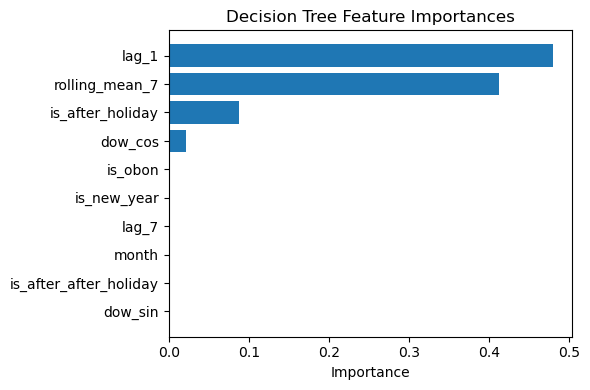

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ------------------------------------------------------------------------------
# 前提：df, feature_columns, y は先ほどと同様に準備済み
# ------------------------------------------------------------------------------
feature_columns = [
    'dow_sin', 'dow_cos',   
    'is_after_holiday','is_after_after_holiday','month',
    'lag_1','lag_7','rolling_mean_7','is_new_year','is_obon',
]
# 2. 平日のみ抽出（祝日は含める）
df_train = df[df['is_weekend'] == False].copy()

X = df_train[feature_columns].copy()
y = df_train['通常物数'].copy()

# ------------------------------------------------------------------------------
# 1. 全データで再学習
# ------------------------------------------------------------------------------
best_params = {
    'max_depth': 3,
    'min_samples_leaf': 5,
    'min_samples_split': 2,
    'random_state': 42
}
model_final = DecisionTreeRegressor(**best_params)
model_final.fit(X, y)

# ------------------------------------------------------------------------------
# 2. モデルの自己評価（全データ学習後の誤差を確認）
# ------------------------------------------------------------------------------
y_pred_full = model_final.predict(X)
mae_full  = mean_absolute_error(y, y_pred_full)
rmse_full = np.sqrt(mean_squared_error(y, y_pred_full))
print(f"Training   MAE: {mae_full:.2f}, RMSE: {rmse_full:.2f}")

# ------------------------------------------------------------------------------
# 3. 翌日予測
# ------------------------------------------------------------------------------
# df の最終行からそのまま特徴量を引っ張る例
X_next = pd.DataFrame([df[feature_columns].iloc[-1].to_dict()])
next_pred = model_final.predict(X_next)[0]
print(f"Next-day forecast: {next_pred:.2f}")

# ------------------------------------------------------------------------------
# 4. 特徴量重要度の可視化
# ------------------------------------------------------------------------------
importances = model_final.feature_importances_
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(6, 4))
plt.barh([feature_columns[i] for i in idx], importances[idx])
plt.xlabel("Importance")
plt.title("Decision Tree Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


[Baseline] Fold 1: MAE = 6041.20, RMSE = 9215.37
[Baseline] Fold 2: MAE = 5370.19, RMSE = 10366.68
[Baseline] Fold 3: MAE = 5948.29, RMSE = 9692.47
[Baseline] Fold 4: MAE = 5313.16, RMSE = 7780.76
[Baseline] Fold 5: MAE = 6168.23, RMSE = 9669.61

[Baseline] Avg MAE = 5768.22, Avg RMSE = 9344.98
Fitting 5 folds for each of 54 candidates, totalling 270 fits

===== Grid Search Result =====
Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
Best CV RMSE: 8977.49477868325

[Final Model] Training MAE: 3154.63, RMSE: 4485.56
Next-day forecast: 39902.99


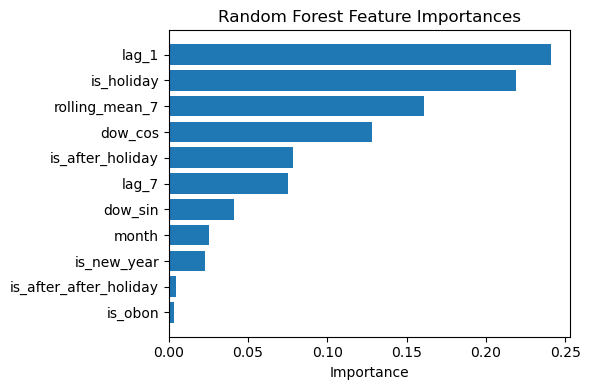

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

feature_columns = [
    'dow_sin', 'dow_cos',   
    'is_after_holiday',
    'is_after_after_holiday',
    'month',
    'lag_1',
    'lag_7',
    'rolling_mean_7',
    'is_new_year',
    'is_obon',
    'is_holiday'
]
# 2. 平日のみ抽出（祝日は含める）
df_train = df[df['is_weekend'] == False].copy()

X = df_train[feature_columns].copy()
y = df_train['通常物数'].copy()

# lag や rolling で生じた NaN を削除
mask = X.isnull().any(axis=1) | y.isnull()
X = X.loc[~mask]
y = y.loc[~mask]

# ------------------------------------------------------------------------------
# 1. ベースライン評価：何もチューニングせずに 5-fold 時系列CV
# ------------------------------------------------------------------------------
tscv = TimeSeriesSplit(n_splits=5)
model_rf = RandomForestRegressor(random_state=42, n_jobs=-1)

mae_list, rmse_list = [], []
for fold, (train_idx, val_idx) in enumerate(tscv.split(X), start=1):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model_rf.fit(X_tr, y_tr)
    y_pred = model_rf.predict(X_val)
    
    mae  = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae_list.append(mae)
    rmse_list.append(rmse)
    
    print(f"[Baseline] Fold {fold}: MAE = {mae:.2f}, RMSE = {rmse:.2f}")

print(f"\n[Baseline] Avg MAE = {np.mean(mae_list):.2f}, Avg RMSE = {np.mean(rmse_list):.2f}")

# ------------------------------------------------------------------------------
# 2. GridSearchCV でハイパーパラメータ最適化
# ------------------------------------------------------------------------------
param_grid = {
    'n_estimators':    [100, 300, 500],
    'max_depth':       [None, 5, 10],
    'min_samples_leaf':[1, 5, 10],
    'max_features':    ['sqrt', 'log2']
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE を目的に
    cv=tscv,
    n_jobs=-1,
    verbose=1
)
grid.fit(X, y)

print("\n===== Grid Search Result =====")
print("Best params:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)

# ------------------------------------------------------------------------------
# 3. 最適パラメータで全データ再学習
# ------------------------------------------------------------------------------
best_rf = RandomForestRegressor(
    **grid.best_params_,
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X, y)

# 自己評価
y_pred_all = best_rf.predict(X)
mae_all  = mean_absolute_error(y, y_pred_all)
rmse_all = np.sqrt(mean_squared_error(y, y_pred_all))
print(f"\n[Final Model] Training MAE: {mae_all:.2f}, RMSE: {rmse_all:.2f}")

# ------------------------------------------------------------------------------
# 4. 翌日予測
# ------------------------------------------------------------------------------
# 最後の行の特徴量を DataFrame に
X_next = pd.DataFrame([df[feature_columns].iloc[-1].to_dict()])
next_pred = best_rf.predict(X_next)[0]
print(f"Next-day forecast: {next_pred:.2f}")

# ------------------------------------------------------------------------------
# 5. 特徴量重要度のプロット
# ------------------------------------------------------------------------------
importances = best_rf.feature_importances_
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(6,4))
plt.barh([feature_columns[i] for i in idx], importances[idx])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [43]:
# XGBoostで学習、予測
import xgboost as xgb  

feature_columns = [
    'dow_sin', 'dow_cos',   
    'is_after_holiday',
    'is_after_after_holiday',
    'month',
    'lag_1',
    'lag_7',
    'rolling_mean_7',
    'is_new_year',
    'is_obon',
    'is_holiday'
]
X = df[feature_columns].copy()
y = df['通常物数'].copy()

# NaN があれば削除
mask = X.isnull().any(axis=1) | y.isnull()
X, y = X.loc[~mask], y.loc[~mask]

# 時系列CV 5分割
tscv = TimeSeriesSplit(n_splits=5)

# XGBoost モデル定義
model_xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

mae_list = []
rmse_list = []

# クロスバリデーション
for fold, (train_idx, val_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # 学習
    model_xgb.fit(X_train, y_train)
    
    # 予測
    y_pred = model_xgb.predict(X_val)
    
    # 評価指標
    mae  = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae_list.append(mae)
    rmse_list.append(rmse)
    
    print(f"Fold {fold}: MAE = {mae:.2f}, RMSE = {rmse:.2f}")

# 結果表示
print("\n===== Cross-Validation Result (TimeSeriesSplit) =====")
print(f"Average MAE : {np.mean(mae_list):.2f}")
print(f"Average RMSE: {np.mean(rmse_list):.2f}")


Fold 1: MAE = 4393.41, RMSE = 8556.65
Fold 2: MAE = 4353.63, RMSE = 9508.89
Fold 3: MAE = 4392.64, RMSE = 8086.47
Fold 4: MAE = 3525.90, RMSE = 6177.43
Fold 5: MAE = 4567.66, RMSE = 8124.15

===== Cross-Validation Result (TimeSeriesSplit) =====
Average MAE : 4246.65
Average RMSE: 8090.72


In [42]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    'n_estimators':    [100, 300, 500, 800],
    'max_depth':       [3, 5, 7, 9],
    'learning_rate':   [0.01, 0.05, 0.1],
    'subsample':       [0.6, 0.8, 1.0],
    'colsample_bytree':[0.6, 0.8, 1.0],
}

grid = GridSearchCV(
    XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    ),
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=TimeSeriesSplit(n_splits=5),
    n_jobs=-1,
    verbose=1
)
grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/Users/hiraokatatsuru/miniconda3/envs/shift_builder/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.6}
Best CV RMSE: 10575.5677734375


Training MAE:  3242.58
Training RMSE: 5850.45
Next-day forecast: 667.94


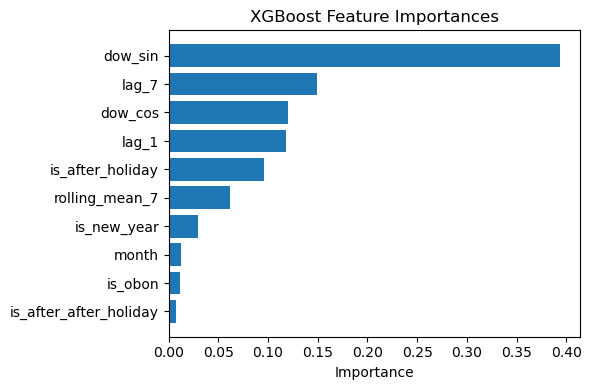

In [43]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 1. 最適パラメータでモデルを定義
best_params = {
    'n_estimators': 100,
    'learning_rate': 0.05,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'n_jobs': -1
}
model_final = XGBRegressor(**best_params)

# 2. 全データ（2021-10～2025-05）で再学習
model_final.fit(X, y)

# 3. 自己評価（全データへの予測誤差を確認）
y_pred_all = model_final.predict(X)
mae_all  = mean_absolute_error(y, y_pred_all)
rmse_all = np.sqrt(mean_squared_error(y, y_pred_all))
print(f"Training MAE:  {mae_all:.2f}")
print(f"Training RMSE: {rmse_all:.2f}")

# 4. 翌日（最終行の次）予測
#    df_feat など最終特徴量を持つ DataFrame からラスト行を取り出す
X_next = X.tail(1)
next_pred = model_final.predict(X_next)[0]
print(f"Next-day forecast: {next_pred:.2f}")

# 5. 特徴量重要度の可視化
importances = model_final.feature_importances_
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(6,4))
plt.barh([feature_columns[i] for i in idx], importances[idx])
plt.xlabel("Importance")
plt.title("XGBoost Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [33]:
import optuna
print(optuna.__version__)


4.3.0


[I 2025-06-09 06:30:34,324] A new study created in memory with name: no-name-202eff2b-87a5-4f2b-b792-928bcdbaaa4e
[I 2025-06-09 06:30:36,885] Trial 0 finished with value: 7543.5029296875 and parameters: {'n_estimators': 207, 'learning_rate': 0.03759299670918603, 'max_depth': 8, 'subsample': 0.5897033593292702, 'colsample_bytree': 0.9565967829704287, 'gamma': 3.5866871618262355, 'reg_alpha': 0.003886366079538868, 'reg_lambda': 0.01100942500034052}. Best is trial 0 with value: 7543.5029296875.
[I 2025-06-09 06:30:37,556] Trial 1 finished with value: 20508.910546875 and parameters: {'n_estimators': 102, 'learning_rate': 0.003716939252167982, 'max_depth': 4, 'subsample': 0.6049877800624688, 'colsample_bytree': 0.7214119638071006, 'gamma': 3.313766237616055, 'reg_alpha': 0.02960259254573041, 'reg_lambda': 0.0003993297057314617}. Best is trial 0 with value: 7543.5029296875.
[I 2025-06-09 06:30:38,744] Trial 2 finished with value: 10053.3107421875 and parameters: {'n_estimators': 96, 'learnin

===== Optuna Result =====
Best params: {'n_estimators': 123, 'learning_rate': 0.08074460174141809, 'max_depth': 4, 'subsample': 0.5628223511360751, 'colsample_bytree': 0.9393015174280657, 'gamma': 0.23069895631758786, 'reg_alpha': 0.00038004740602587097, 'reg_lambda': 0.00043478659626749463}
Best CV MAE: 6755.34013671875

Full-data Training MAE: 4460.03
Next-day forecast: 4685.65


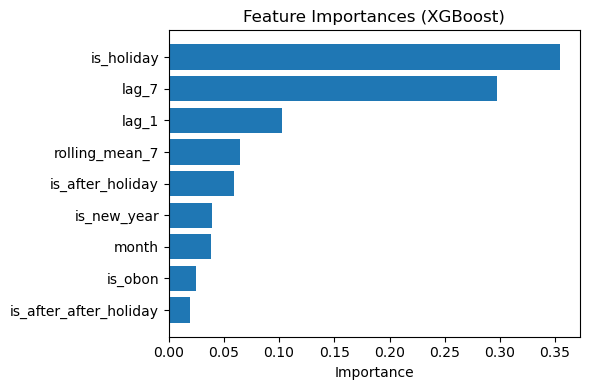

In [48]:
import numpy as np
import pandas as pd
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# 1. データ & 特徴量準備
# ------------------------------------------------------------------------------
# ここでは df_weekday が前提。すでに必要なフラグ／ラグ列が入っているものとします。
feature_columns = [
    #'dow_sin', 'dow_cos',   
    'is_after_holiday',
    'is_after_after_holiday',
    'month',
    'lag_1',
    'lag_7',
    'rolling_mean_7',
    'is_new_year',
    'is_obon',
    'is_holiday'
]
X = df[feature_columns].copy()
y = df['通常物数'].copy()

# 欠損行を落とす
mask = X.isnull().any(axis=1) | y.isnull()
X, y = X.loc[~mask], y.loc[~mask]

# ------------------------------------------------------------------------------
# 2. TimeSeriesSplit (5分割)
# ------------------------------------------------------------------------------
tscv = TimeSeriesSplit(n_splits=5)

# ------------------------------------------------------------------------------
# 3. Optuna 目的関数定義
# ------------------------------------------------------------------------------
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 10.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'objective': 'reg:squarederror',
    }
    mae_scores = []
    for train_idx, val_idx in tscv.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model = XGBRegressor(**params)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        mae_scores.append(mean_absolute_error(y_val, y_pred))
    return float(np.mean(mae_scores))

# ------------------------------------------------------------------------------
# 4. スタディ実行
# ------------------------------------------------------------------------------
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)

print("===== Optuna Result =====")
print("Best params:", study.best_params)
print("Best CV MAE:", study.best_value)

# ------------------------------------------------------------------------------
# 5. 最適モデルで全データ再学習＆自己評価
# ------------------------------------------------------------------------------
best_params = study.best_params
best_params.update({
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror',
})
model_final = XGBRegressor(**best_params)
model_final.fit(X, y)

y_pred_all = model_final.predict(X)
mae_all = mean_absolute_error(y, y_pred_all)
print(f"\nFull-data Training MAE: {mae_all:.2f}")

# ------------------------------------------------------------------------------
# 6. 翌日予測
# ------------------------------------------------------------------------------
X_next = X.tail(1)
next_pred = model_final.predict(X_next)[0]
print(f"Next-day forecast: {next_pred:.2f}")

# ------------------------------------------------------------------------------
# 7. 特徴量重要度のプロット
# ------------------------------------------------------------------------------
importances = model_final.feature_importances_
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(6,4))
plt.barh([feature_columns[i] for i in idx], importances[idx])
plt.xlabel("Importance")
plt.title("Feature Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [24]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import jpholiday

# 1. 学習/テスト分割（直近4週間をテスト）
split_date = df.index.max() - pd.Timedelta(weeks=4)
train_df = df[df.index <= split_date]
test_df  = df[df.index > split_date]

feature_columns = [
    #'dow_sin', 'dow_cos',   
    'is_after_holiday',
    'is_after_after_holiday',
    'month',
    'lag_1',
    'lag_7',
    'rolling_mean_7',
    'is_new_year',
    'is_obon',
    'is_holiday'
]
X_train, y_train = train_df[feature_columns], train_df['通常物数']
X_test,  y_test  = test_df[feature_columns],  test_df['通常物数']

# 2. モデル定義＆学習
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)

# 3. 予測
y_pred_raw = model.predict(X_test)
preds = pd.Series(y_pred_raw, index=X_test.index)

# 4. 土日0 & 祝日繰り越し
preds[preds.index.weekday >= 5] = 0
for d in preds.index[preds.index.to_series().apply(jpholiday.is_holiday)]:
    amt = preds.at[d]
    preds.at[d] = 0
    next_day = d + pd.Timedelta(days=1)
    while next_day.weekday() >= 5 or jpholiday.is_holiday(next_day):
        next_day += pd.Timedelta(days=1)
    preds.at[next_day] = preds.get(next_day, 0) + amt

# 5. 評価
preds = preds.reindex(y_test.index, fill_value=0)
mae  = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"Test MAE:  {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")


Test MAE:  3339.90
Test RMSE: 8586.99


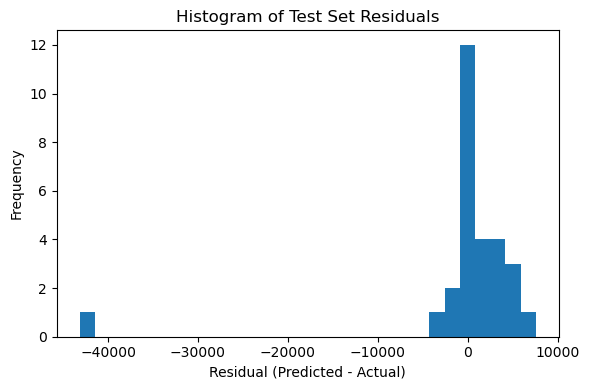

In [25]:
residuals = preds - y_test

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.xlabel("Residual (Predicted - Actual)")
plt.ylabel("Frequency")
plt.title("Histogram of Test Set Residuals")
plt.tight_layout()
plt.show()

<Axes: xlabel='weekday', ylabel='residual'>

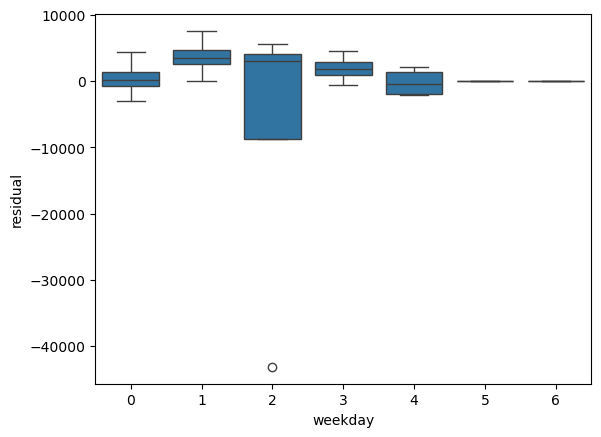

In [26]:
import seaborn as sns
df_res = pd.DataFrame({
    'residual': residuals,
    'weekday': residuals.index.weekday
})
sns.boxplot(data=df_res, x='weekday', y='residual')

In [19]:
def apply_business_rules(preds: pd.Series) -> pd.Series:
    # (A) 土日を 0
    preds = preds.copy()
    preds[preds.index.weekday >= 5] = 0

    # (B) 祝日を翌営業日に繰り越し
    for d in preds.index[preds.index.to_series().apply(jpholiday.is_holiday)]:
        amt = preds.at[d]
        preds.at[d] = 0
        next_day = d + pd.Timedelta(days=1)
        while next_day.weekday() >= 5 or jpholiday.is_holiday(next_day):
            next_day += pd.Timedelta(days=1)
        preds.at[next_day] = preds.get(next_day, 0) + amt

    return preds


In [20]:
pred_xgb = pd.Series(model_xgb.predict(X_test), index=X_test.index)
pred_rf  = pd.Series(model_rf.predict(X_test),  index=X_test.index)

# 2) ルールを適用
adj_xgb = apply_business_rules(pred_xgb)
adj_rf  = apply_business_rules(pred_rf)

NameError: name 'model_xgb' is not defined

In [21]:
# 単純平均
ens = (adj_xgb + adj_rf) / 2

# 重み付き平均（例：XGBoost に 60%／RF に 40%）
w = 0.6
ens_w = adj_xgb * w + adj_rf * (1 - w)


NameError: name 'adj_xgb' is not defined

In [64]:
from sklearn.metrics import mean_absolute_error
import numpy as np

mae  = mean_absolute_error(y_test, ens)
rmse = np.sqrt(mean_squared_error(y_test, ens))
print("Ensemble MAE :", mae)
print("Ensemble RMSE:", rmse)


Ensemble MAE : 5092.853759765625
Ensemble RMSE: 7401.659049465596


In [65]:

best_mae, best_w = np.inf, None
for w in np.linspace(0,1,21):
    y_ens = w * adj_xgb + (1-w) * adj_rf
    mae  = mean_absolute_error(y_test, y_ens)
    rmse = np.sqrt(mean_squared_error(y_test, y_ens))
    if mae < best_mae:
        best_mae, best_w = mae, w

print(f"Best w: {best_w:.2f}, Ensemble MAE: {best_mae:.2f}")


Best w: 0.60, Ensemble MAE: 4910.21


In [72]:
import numpy as np
import pandas as pd
import jpholiday
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 事前：df で特徴量と '通常物数' が準備済み
split_date = df.index.max() - pd.Timedelta(weeks=4)
train_df = df[df.index <= split_date]
test_df  = df[df.index >  split_date]
feature_columns = [
    #'dow_sin', 'dow_cos',   
    'is_after_holiday',
    'is_after_after_holiday',
    'month',
    'lag_1',
    'lag_7',
    'rolling_mean_7',
    'is_new_year',
    'is_obon',
]

X_train = train_df[feature_columns]
y_train = train_df['通常物数']
X_test  = test_df[feature_columns]
y_test  = test_df['通常物数']

# レベル0モデル（ベストパラメータ）
# 2. レベル0モデル
model_xgb = XGBRegressor(
    n_estimators=264,
    learning_rate=0.0265753947,
    max_depth=3,
    subsample=0.9522,
    colsample_bytree=0.6075,
    gamma=3.9151,
    reg_alpha=0.7657,
    reg_lambda=0.05785,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)
model_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# 1. OOF 予測用の枠を作成
oof = pd.DataFrame(index=X_train.index, columns=['xgb','rf'])
tscv = TimeSeriesSplit(n_splits=5)

for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr = y_train.iloc[train_idx]
    # 学習
    model_xgb.fit(X_tr, y_tr)
    model_rf.fit(X_tr, y_tr)
    # 予測を格納
    oof.loc[X_train.index[val_idx], 'xgb'] = model_xgb.predict(X_val)
    oof.loc[X_train.index[val_idx],  'rf'] = model_rf.predict(X_val)

# 2. メタモデル学習
meta = RidgeCV(alphas=[0.1,1.0,10.0])
meta.fit(oof.astype(float), y_train)

# 3. テストセットでレベル0を再学習＆予測
model_xgb.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
pred_xgb_test = model_xgb.predict(X_test)
pred_rf_test  = model_rf.predict(X_test)
meta_input    = np.vstack([pred_xgb_test, pred_rf_test]).T
y_pred_stack  = meta.predict(meta_input)

# 4. ビジネスルール適用
preds = pd.Series(y_pred_stack, index=X_test.index)
preds[preds.index.weekday >= 5] = 0
for d in preds.index[preds.index.to_series().apply(jpholiday.is_holiday)]:
    amt = preds.at[d]; preds.at[d] = 0
    nd = d + pd.Timedelta(days=1)
    while nd.weekday() >= 5 or jpholiday.is_holiday(nd):
        nd += pd.Timedelta(days=1)
    preds.at[nd] = preds.get(nd,0) + amt

# 5. 評価
mae  = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"Manual Stacking MAE : {mae:.2f}")
print(f"Manual Stacking RMSE: {rmse:.2f}")


ValueError: Input X contains NaN.
_RidgeGCV does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [49]:
import pandas as pd
import numpy as np
import jpholiday

# ─── 前提 ───
# df: 日次インデックス付きの DataFrame。lag, rolling_mean, dow_sin/cos,
#     is_holiday, is_after_holiday, is_after_after_holiday, month, is_new_year, is_obon が揃っている
# final_model: 最新の XGBRegressor（Optuna→全データ再学習で得たもの）

feature_columns = [
    #'dow_sin','dow_cos',
    'is_after_holiday','is_after_after_holiday',
    'month','lag_1','lag_7','rolling_mean_7','is_new_year','is_obon','is_holiday'
]

# 予測開始とインデックス生成（翌日〜30日後）
last_date   = df.index.max()
#future_idx  = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')
future_idx = pd.date_range(start=last_date + BDay(1), periods=365, freq='B')
# 履歴と予測結果を用意
history   = df['通常物数'].copy()
forecasts = pd.Series(dtype=float, index=future_idx)
carry     = 0.0

for current_date in future_idx:
    # ① 特徴量辞書を作成（is_holiday も忘れずに）
    feat = {
        #'dow_sin':                np.sin(2 * np.pi * current_date.weekday() / 7),
        #'dow_cos':                np.cos(2 * np.pi * current_date.weekday() / 7),
        'is_after_holiday':       int(jpholiday.is_holiday(current_date - pd.Timedelta(days=1))),
        'is_after_after_holiday': int(jpholiday.is_holiday(current_date - pd.Timedelta(days=2))),
        'month':                  current_date.month,
        'lag_1':                  history.get(current_date - pd.Timedelta(days=1),   np.nan),
        'lag_7':                  history.get(current_date - pd.Timedelta(days=7),   np.nan),
        'rolling_mean_7':         history.shift(1).rolling(7).mean().get(current_date, np.nan),
        'is_new_year':            int(current_date.month == 1 and current_date.day <= 3),
        'is_obon':                int(current_date.month == 8 and 13 <= current_date.day <= 16),
        'is_holiday':             int(jpholiday.is_holiday(current_date))
    }
    # ② DataFrame 化して列順を合わせる
    X_cur = pd.DataFrame([feat], index=[current_date])[feature_columns]
    raw_pred = model_final.predict(X_cur)[0]

    # ③ ビジネスルール適用
    if current_date.weekday() >= 5:
        # 土日は 0
        pred = 0.0
    elif feat['is_holiday'] == 1:
        # 祝日はキャリーに溜め込み
        carry += raw_pred
        pred = 0.0
    else:
        # 平日はキャリー分を足してリセット
        pred  = raw_pred + carry
        carry = 0.0

    # ④ 結果保存 & 履歴に追加
    forecasts[current_date] = pred
    history[current_date]   = pred

# ⑤ データフレーム化・確認
forecast_df = forecasts.to_frame(name='forecast')
print(forecast_df.to_string())


                 forecast
2025-06-02   52975.312500
2025-06-03   75501.132812
2025-06-04   74330.421875
2025-06-05   74691.406250
2025-06-06   74491.218750
2025-06-09   54733.933594
2025-06-10   73272.812500
2025-06-11   74438.921875
2025-06-12   73818.304688
2025-06-13   74438.921875
2025-06-16   55038.410156
2025-06-17   73272.812500
2025-06-18   74438.921875
2025-06-19   73818.304688
2025-06-20   74438.921875
2025-06-23   56295.714844
2025-06-24   74083.781250
2025-06-25   73818.304688
2025-06-26   74438.921875
2025-06-27   73818.304688
2025-06-30   56295.714844
2025-07-01   74083.781250
2025-07-02   73818.304688
2025-07-03   74438.921875
2025-07-04   73818.304688
2025-07-07   56295.714844
2025-07-08   74083.781250
2025-07-09   73818.304688
2025-07-10   74438.921875
2025-07-11   73818.304688
2025-07-14   56295.714844
2025-07-15   74083.781250
2025-07-16   73818.304688
2025-07-17   74438.921875
2025-07-18   73818.304688
2025-07-21       0.000000
2025-07-22  157750.109375
2025-07-23  